<a href="https://colab.research.google.com/github/lidorsandak/ad_ML_Competition_m5/blob/main/data_eda_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# M5 Forecasting Challenge: Predicting Daily Walmart Revenue: EDA and Preprocessing

**Course:** Advanced Machine Learning - Final Assignment

---

In [2]:
# Cell 1: Setup and Data Loading
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# First, you might need to install Optuna
!pip install optuna -q

import optuna

# General imports
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random
from statsmodels.tsa.seasonal import seasonal_decompose

from math import ceil

from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.9 MB/s eta 0:00:00


Load Main Data

In [4]:
# Define path to your data on Google Drive
DATA_PATH = '/content/drive/MyDrive/M5_Project/'


train_df = pd.read_csv(DATA_PATH + 'train.csv')
calendar_df = pd.read_csv(DATA_PATH + 'calendar_events.csv')
sample_submission = pd.read_csv(DATA_PATH + 'forecast_submission.csv')

Explore train data

In [5]:
print('  unique forecasts: %i' % train_df.shape[0])
for col in train_df.columns:
  print('   N_unique %s: %i' % (col, train_df[col].nunique()))

train_df.head()


  unique forecasts: 18766
   N_unique store_id: 11
   N_unique store_name: 11
   N_unique date: 1706
   N_unique revenue: 18624


,store_id,store_name,date,revenue
0,0,All Stores,2011-01-29,204126.52
1,0,All Stores,2011-01-30,197426.42
2,0,All Stores,2011-01-31,144267.27
3,0,All Stores,2011-02-01,151903.00
4,0,All Stores,2011-02-02,117399.88


In [6]:
# Check for missing dates per store
def check_missing_dates(df):
    """Identify gaps in the time series for each store"""
    df['date'] = pd.to_datetime(df['date'])

    for store_id in df['store_id'].unique():
        store_data = df[df['store_id'] == store_id].sort_values('date')
        date_range = pd.date_range(start=store_data['date'].min(),
                                     end=store_data['date'].max(),
                                     freq='D')
        missing_dates = date_range.difference(store_data['date'])

        if len(missing_dates) > 0:
            print(f"Store {store_id}: {len(missing_dates)} missing dates")
            print(f"  First few: {missing_dates[:5].tolist()}")

check_missing_dates(train_df)

In [7]:

summary_by_store = train_df.groupby('store_id').agg(
    min_date=('date', 'min'),
    max_date=('date', 'max'),
    min_revenue=('revenue', 'min'),
    max_revenue=('revenue', 'max'),
    avg_revenue=('revenue', 'mean') # It's also useful to see the average
).reset_index()

# Improve formatting for readability
summary_by_store['min_revenue'] = summary_by_store['min_revenue'].round(2)
summary_by_store['max_revenue'] = summary_by_store['max_revenue'].round(2)
summary_by_store['avg_revenue'] = summary_by_store['avg_revenue'].round(2)

# Display the resulting table
print("Summary of Data Range and Revenue by Store ID:")
display(summary_by_store)

Summary of Data Range and Revenue by Store ID:


,store_id,min_date,max_date,min_revenue,max_revenue,avg_revenue
0,0,2011-01-29,2015-09-30,59.20,394304.00,237057.45
1,1,2011-01-29,2015-09-30,0.00,53079.07,28756.90
2,2,2011-01-29,2015-09-30,7.90,46946.10,21393.61
3,3,2011-01-29,2015-09-30,0.00,69466.55,41134.34
4,4,2011-01-29,2015-09-30,0.00,24894.20,15469.16
5,5,2011-01-29,2015-09-30,0.00,38790.60,20081.25
6,6,2011-01-29,2015-09-30,0.00,50754.12,26304.04
7,7,2011-01-29,2015-09-30,3.95,50970.07,22268.39
8,8,2011-01-29,2015-09-30,0.00,50715.82,18289.56
9,9,2011-01-29,2015-09-30,0.00,43798.95,21709.92


In [8]:
# Check for zero/negative revenues (potential data issues)
print("\nZero revenue counts by store:")
print(train_df[train_df['revenue'] == 0].groupby('store_id').size())

print("\nNegative revenue counts:")
print((train_df['revenue'] < 0).sum())


Zero revenue counts by store:
store_id
1     4
3     1
4     4
5     3
6     2
8     3
9     2
10    2
dtype: int64

Negative revenue counts:
0


Explore submission dates

In [9]:
# The submission file ID is store_id + date (YYYYMMDD)
# We need to parse the date part of the 'id' string.
submission_ids = sample_submission['id'].str.split('_', expand=True)
submission_ids.columns = ['store_id_str', 'date_str']
submission_dates = pd.to_datetime(submission_ids['date_str'], format='%Y%m%d')

H = submission_dates.nunique()
print(f"The Forecast Horizon (H) is: {H} days.")

# Now find the min and max dates
min_submission_date = submission_dates.min()
max_submission_date = submission_dates.max()

# Calculate the duration (our forecast horizon H)
num_forecast_days = (max_submission_date - min_submission_date).days + 1

print(f"Submission File Analysis:")
print(f"-------------------------")
print(f"Forecast Start Date: {min_submission_date.date()}")
print(f"Forecast End Date:   {max_submission_date.date()}")
print(f"Total Forecast Horizon (H): {num_forecast_days} days")

The Forecast Horizon (H) is: 92 days.
Submission File Analysis:
-------------------------
Forecast Start Date: 2015-10-01
Forecast End Date:   2015-12-31
Total Forecast Horizon (H): 92 days


##### **Data Merging and Preparation**

In [10]:
# Convert 'date' columns to datetime objects
train_df['date'] = pd.to_datetime(train_df['date'])
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

# Merge train_df with calendar_df to get all features in one place
original_df = pd.merge(train_df, calendar_df, on='date', how='left')
original_df['event'].fillna('NoEvent', inplace=True)

print("\nData merged:")
original_df.head()



Data merged:


,store_id,store_name,date,revenue,event
0,0,All Stores,2011-01-29,204126.52,NoEvent
1,0,All Stores,2011-01-30,197426.42,NoEvent
2,0,All Stores,2011-01-31,144267.27,NoEvent
3,0,All Stores,2011-02-01,151903.00,NoEvent
4,0,All Stores,2011-02-02,117399.88,NoEvent


--------------


## EDA



*   Temporal Patterns Analysis
    *   Overall Trend
    *   Seasonality Detection
    *   Year-over-Year Growth
*   Store-Level Analysis
    * Revenue Distribution Across Stores
    * Store Time Series Comparison
* Stationarity & Autocorrelation
* Event/Anomaly Detection
* Correlation Analysis
* Decomposition Analysis



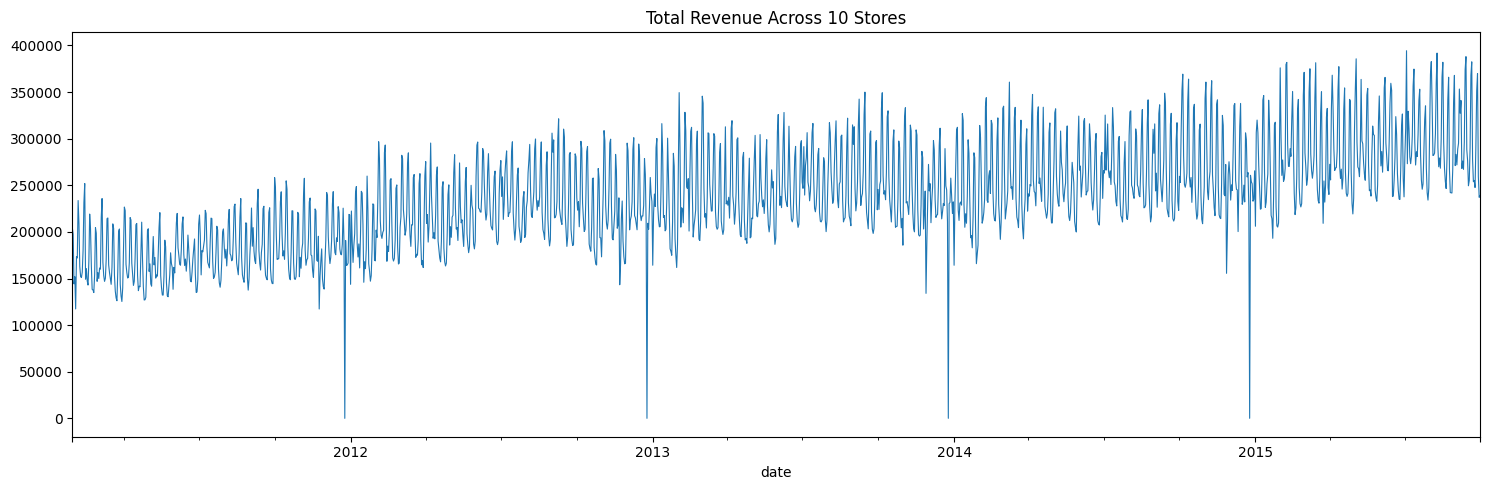

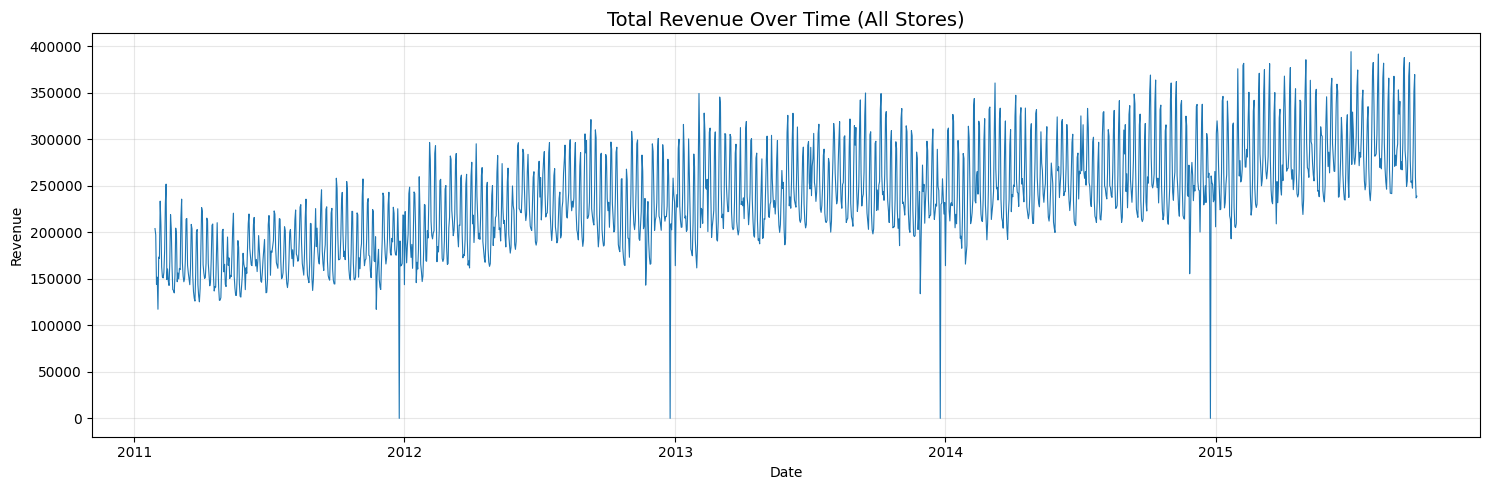

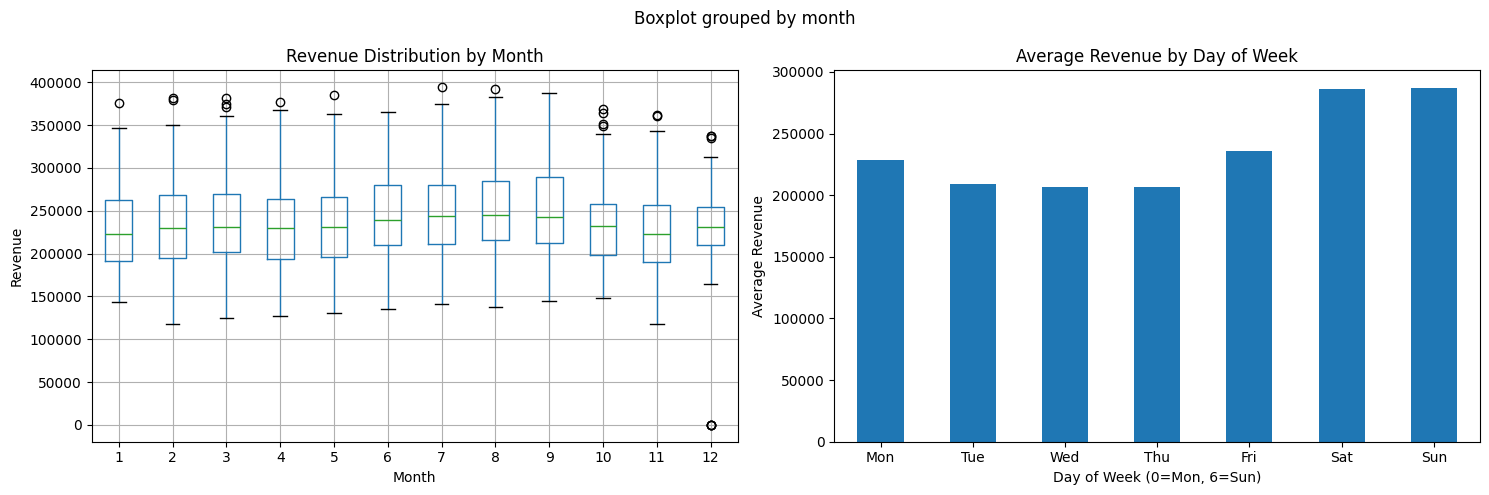

Year-over-Year Revenue (Jan-Sep only):
year
2011    42508947.85
2012    60947057.58
2013    67418155.32
2014    70385002.43
2015    78605456.31
Name: revenue, dtype: float64

YoY Growth Rate:
year
2011          NaN
2012    43.374656
2013    10.617572
2014     4.400665
2015    11.679269
Name: revenue, dtype: float64


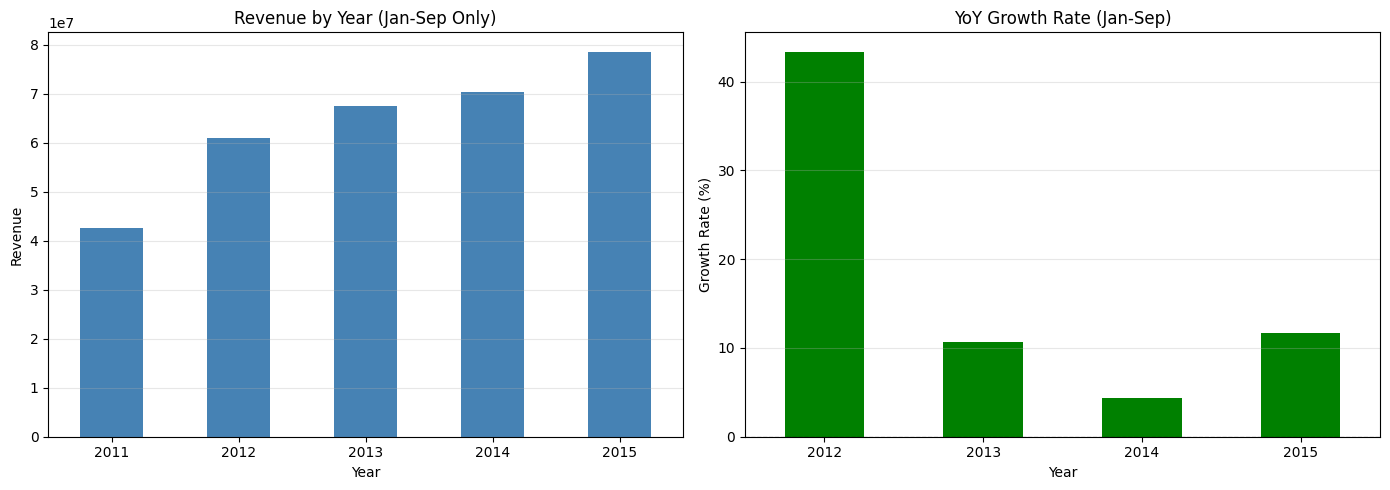

In [11]:
# ------------------- Temporal Patterns Analysis ---------------------

# A. Overall Trend

# Plot aggregate revenue over time
df_agg = train_df[train_df['store_id'] == 0].copy()
df_agg = df_agg.sort_values('date')

# Plot 1: Aggregate Revenue (across the 10 real stores)
train_stores= train_df[train_df['store_id'] != 0].copy()
df_sum=train_stores.groupby('date')['revenue'].sum()
df_sum.plot(title='Total Revenue Across 10 Stores', linewidth=0.8, figsize=(15, 5))
plt.tight_layout()
plt.show()

# Plot 2: Weekly Seasonality

plt.figure(figsize=(15, 5))
plt.plot(df_agg['date'], df_agg['revenue'], linewidth=0.8)
plt.title('Total Revenue Over Time (All Stores)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# B. Seasonality Detection

# Extract temporal features
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day_of_week'] = train_df['date'].dt.dayofweek
train_df['quarter'] = train_df['date'].dt.quarter

# Monthly seasonality
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Boxplot by month
train_df[train_df['store_id'] == 0].boxplot(column='revenue', by='month', ax=axes[0])
axes[0].set_title('Revenue Distribution by Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Revenue')

# Average revenue by day of week
train_df[train_df['store_id'] == 0].groupby('day_of_week')['revenue'].mean().plot(kind='bar', ax=axes[1])
axes[1].set_title('Average Revenue by Day of Week')
axes[1].set_xlabel('Day of Week (0=Mon, 6=Sun)')
axes[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
axes[1].set_ylabel('Average Revenue')

plt.tight_layout()
plt.show()

# C. Compare Same Time Periods

# Filter to only Jan-Sep for all years to make fair comparisons
df_total = train_df[train_df['store_id'] == 0].copy()
df_total['date'] = pd.to_datetime(df_total['date'])
df_total['year'] = df_total['date'].dt.year
df_total['month'] = df_total['date'].dt.month

# Only use Jan-Sep (months 1-9) for all years
df_comparable = df_total[df_total['month'] <= 9]

yearly_revenue = df_comparable.groupby('year')['revenue'].sum()

print("Year-over-Year Revenue (Jan-Sep only):")
print(yearly_revenue)
print("\nYoY Growth Rate:")
yoy_growth = yearly_revenue.pct_change() * 100
print(yoy_growth)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
yearly_revenue.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Revenue by Year (Jan-Sep Only)', fontsize=12)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Revenue')
axes[0].set_xticklabels(yearly_revenue.index, rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Growth rate
yoy_growth.dropna().plot(kind='bar', ax=axes[1], color=['red' if x < 0 else 'green' for x in yoy_growth.dropna()])
axes[1].set_title('YoY Growth Rate (Jan-Sep)', fontsize=12)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Growth Rate (%)')
axes[1].axhline(0, color='black', linewidth=0.8, linestyle='--')
axes[1].set_xticklabels(yoy_growth.dropna().index, rotation=0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**Insights and Modeling Implication**

- Weekly Seasonality:
    - Include day_of_week and is_weekend as features
    - Consider a weekly seasonal component in time series models (e.g., seasonal_period=7 in SARIMA)
- Monthly Seasonality:
    - The business is not highly seasonal at the monthly level
    - Events/holidays matter more than the month itself: Q4 outliers suggest end-of-year shopping boost
    - For model we should handle the events outliers so they won't skew our model
- Variance and Outliers
    - heteroscedasticity - variance increases over time

Holiday drops must be handled:
- Flag them as outliers and exclude from training
- Create is_holiday feature with special handling
- Use a model robust to outliers (e.g., Huber loss)


Key Takeaways:

* Log transformation is critical here (np.log1p(revenue)) in order to stabilize the increasing variance and makes the model multiplicative rather than an additive model
* Consider exogenous holiday variables
* The trend is not perfectly linear - might benefit from polynomial features or tree-based models

| Priority | Feature | Why |
|---|---|---|
| 🔥 **CRITICAL** | `day_of_week` / `is_weekend` | 40% weekend lift - massive signal |
| 🔥 **CRITICAL** | `is_holiday` / `event` | Explains the near-zero revenue days |
| 🔥 **CRITICAL** | Log transformation | Handles increasing variance |
| ⭐ **Important** | Lag features (you have these) | Revenue is autocorrelated (weekly pattern) |
| ⭐ **Important** | Rolling averages (you have these) | Smooth out noise, capture trends |
| 💡 **Helpful** | `month` / `quarter` | Mild seasonal effect, Q4 boost |
| 💡 **Helpful** | Year-based trend features | Capture the non-linear growth |

Model Selection Guidance:
Given these patterns, good model choices are:

1. Tree-Based Models (XGBoost, LightGBM):
- ✅ Handle non-linear growth pattern
- ✅ Automatically learn interactions (weekend × holiday)
- ✅ Robust to outliers
- ✅ Can handle your lag/rolling features well

2. SARIMA / Prophet (if you want pure time series):
- ✅ SARIMA with seasonal_order=(0,0,0,7) for weekly pattern
- ✅ Prophet excellent for handling holidays/events
- ⚠️ May struggle with the non-linear growth trend

3. Hybrid Approach (Recommended):
- Use Prophet/SARIMA for trend + seasonality
- Use XGBoost for the residuals (event effects, store-specific patterns)

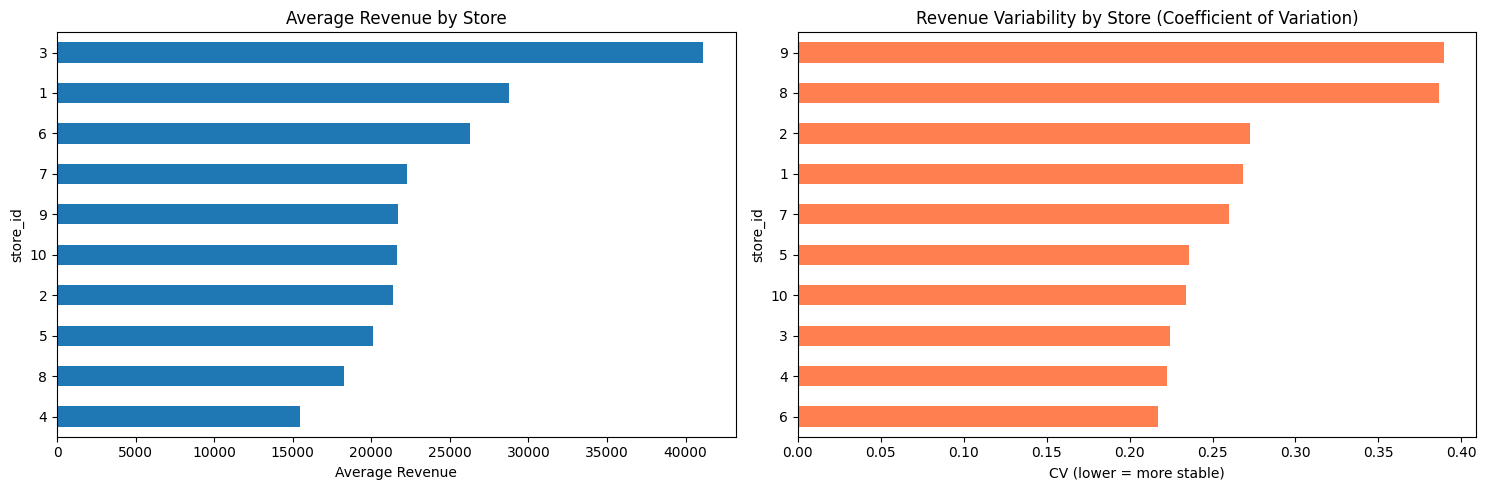

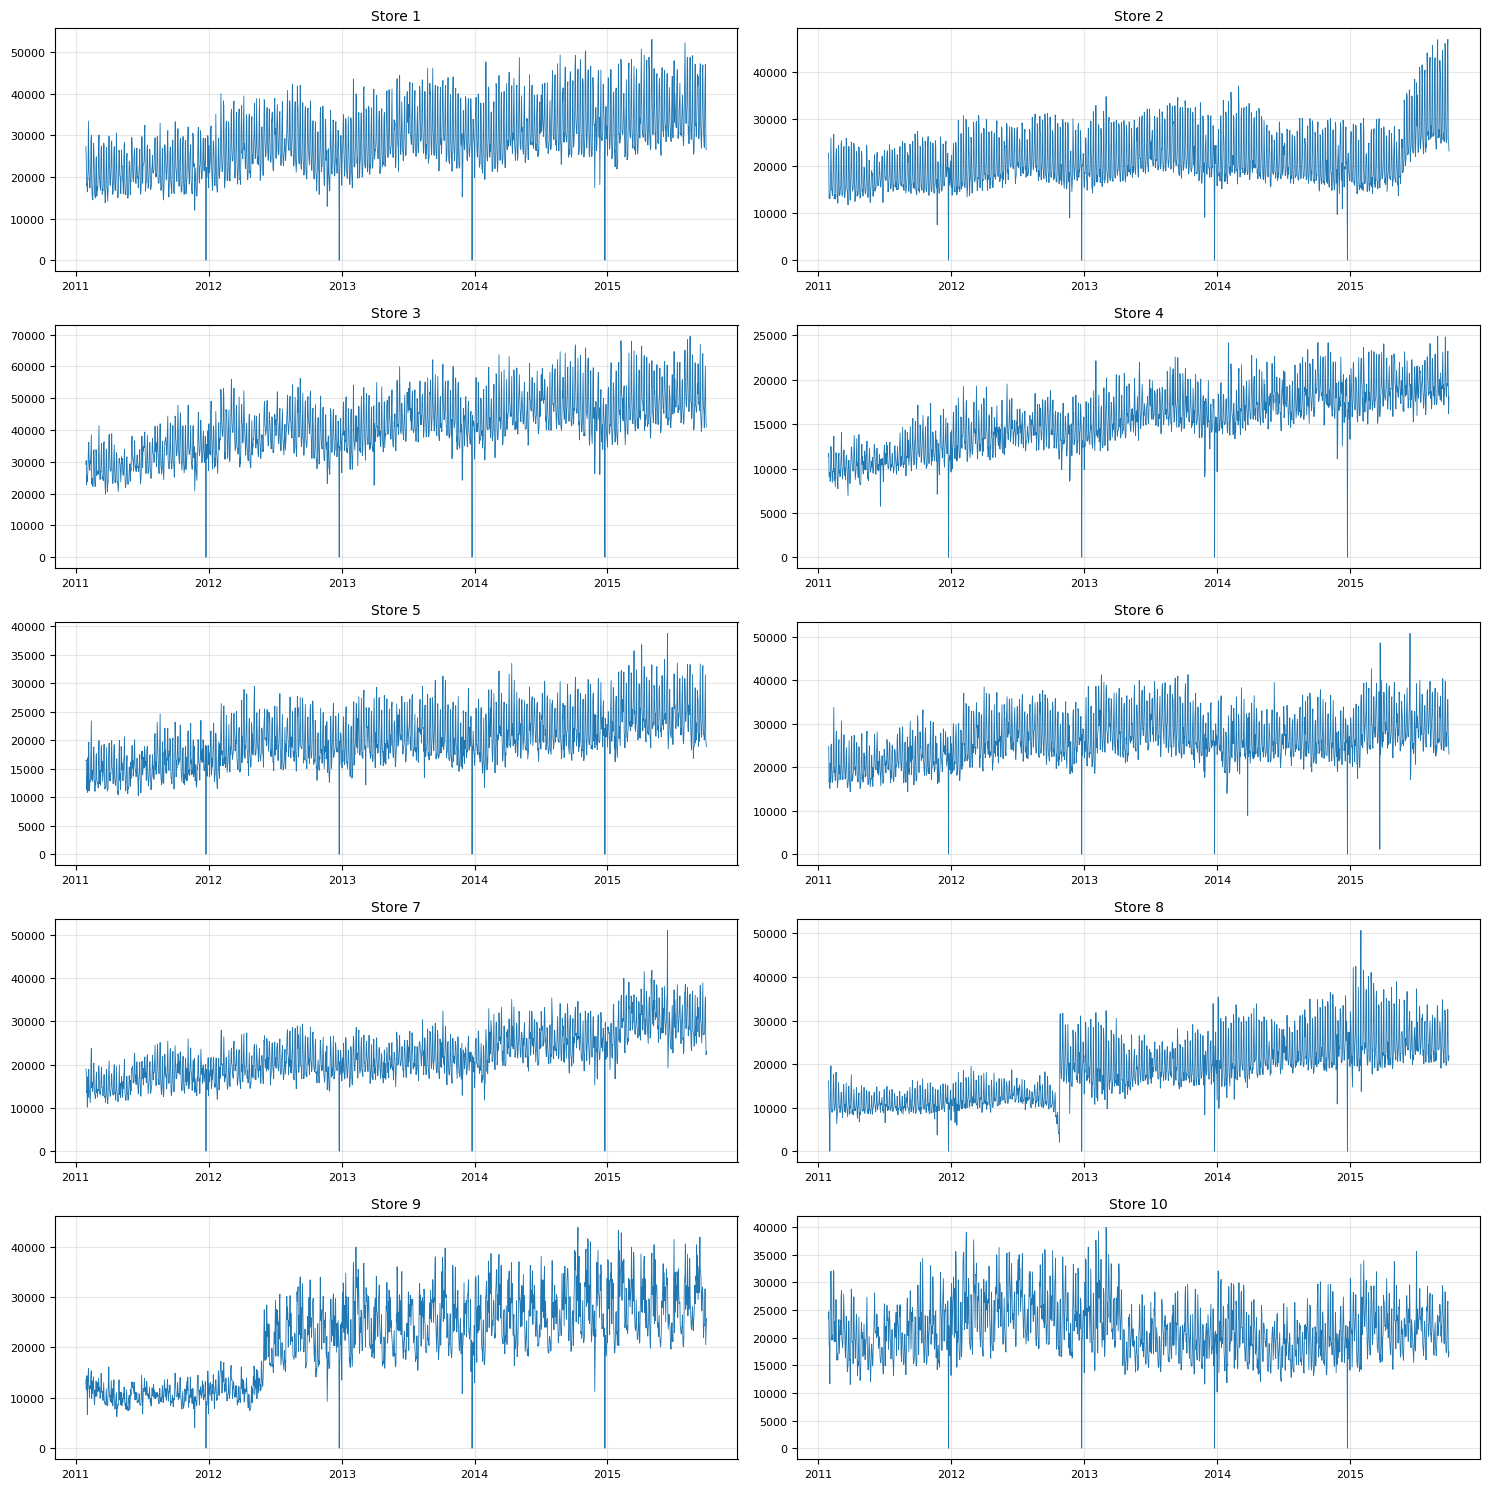

In [12]:
# ------------------- Store-Level Analysis ---------------------

# A.  Revenue Distribution Across Stores
df_stores = train_df[train_df['store_id'] != 0].copy()

# Average revenue by store
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

store_avg = df_stores.groupby('store_id')['revenue'].mean().sort_values()
store_avg.plot(kind='barh', ax=axes[0])
axes[0].set_title('Average Revenue by Store')
axes[0].set_xlabel('Average Revenue')

# Revenue variability by store (coefficient of variation)
store_cv = (df_stores.groupby('store_id')['revenue'].std() /
            df_stores.groupby('store_id')['revenue'].mean()).sort_values()
store_cv.plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title('Revenue Variability by Store (Coefficient of Variation)')
axes[1].set_xlabel('CV (lower = more stable)')

plt.tight_layout()
plt.show()

# B. Store Time Series Comparison
# Plot individual store trends
fig, axes = plt.subplots(5, 2, figsize=(15, 15))
axes = axes.flatten()

for i, store_id in enumerate(range(1, 11)):
    store_data = train_df[train_df['store_id'] == store_id].sort_values('date')
    axes[i].plot(store_data['date'], store_data['revenue'], linewidth=0.6)
    axes[i].set_title(f'Store {store_id}', fontsize=10)
    axes[i].tick_params(labelsize=8)
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

*Revenue Scale*

**High Revenue Tier:**

Store 3: ~$41K avg

Store 1: ~$29K avg

Store 6: ~$26K avg

**Middle Tier:**

Stores 7, 9, 10, 2, 5: ~$20-22K avg

**Low Revenue Tier**

Store 8: ~$18K avg

Store 4: ~$15K avg


Modeling Implication:
- Separate models per store (recommended, given clear tiers)
- Store ID as a categorical feature with embeddings (if using neural networks)
- Hierarchical/grouped forecasting (forecast total, then allocate to stores)


*Revenue Volatility: Stability vs. Unpredictability*

Most Stable (Easiest to Forecast):

- Store 6: CV ≈ 0.21 (🎯 most predictable)
- Store 4: CV ≈ 0.23
- Store 3: CV ≈ 0.24

Most Volatile (Hardest to Forecast):

- Store 9: CV ≈ 0.41 (⚠️ highly erratic)
- Store 8: CV ≈ 0.40
- Store 2: CV ≈ 0.28

Store 3 (highest revenue) is relatively stable, while Store 4 (lowest revenue) is also stable. Meanwhile, mid-tier stores like 8 and 9 are highly volatile.

Modeling Implication:
- Separate error bounds for each store, Store 9 will need wider prediction intervals
- More complex features needed for volatile stores (lag features, external data like weather/events)
- Simpler models may work for stable stores (Store 3, 4, 6)
Consider quantile regression for stores with high CV to capture uncertainty


Key Takeaways:

- Store 8

"# Create a regime indicator for Store 8
df.loc[(df['store_id'] == 8) & (df['date'] < '2012-06-01'), 'store_8_regime'] = 0
df.loc[(df['store_id'] == 8) & (df['date'] >= '2012-06-01'), 'store_8_regime'] = 1"

- Consider Store Clustering
  
  Instead of 10 separate models, group similar stores:
  
  Cluster A (High Growth): Stores 1, 3, 7

      Use models with strong trend components

  Cluster B (Stable/Mature): Stores 4, 6, 10

      Emphasize seasonality over trend

  Cluster C (Volatile): Stores 2, 8, 9

      Use robust models, more features, wider prediction intervals

  Cluster D (Middle): Store 5

      Standard approach


Total Revenue Stationarity Test
ADF Statistic: -1.5077
p-value: 0.5297
Critical Values:
  1%: -3.434
  5%: -2.863
  10%: -2.568
✗ Series is non-stationary (fail to reject null hypothesis)


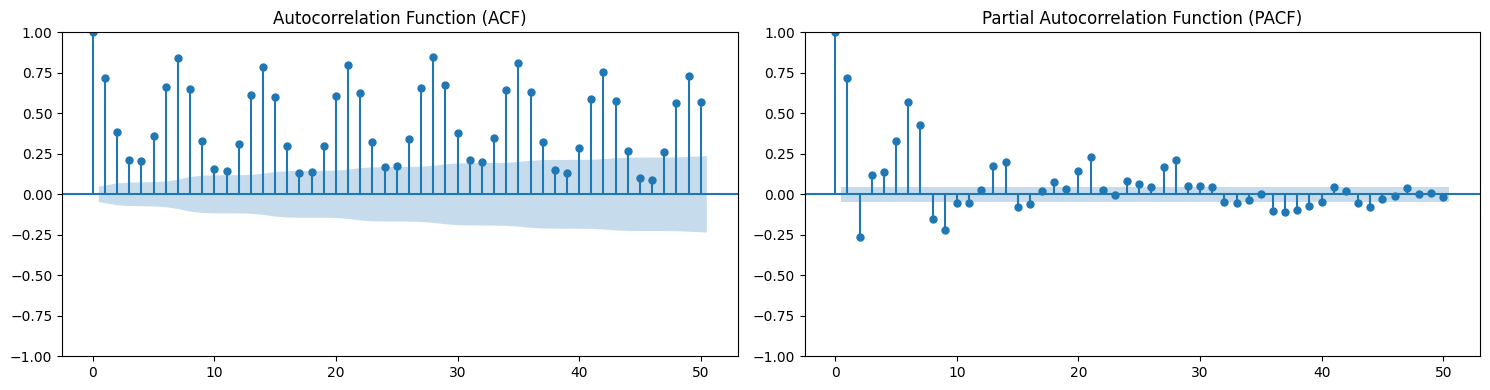

In [13]:
# ------------------- Stationarity & Autocorrelation ---------------------


# Test for stationarity (Augmented Dickey-Fuller test)
def test_stationarity(timeseries, title):
    result = adfuller(timeseries.dropna())
    print(f'\n{title}')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'  {key}: {value:.3f}')

    if result[1] <= 0.05:
        print("✓ Series is stationary (reject null hypothesis)")
    else:
        print("✗ Series is non-stationary (fail to reject null hypothesis)")

# Test on aggregate revenue
df_total = train_df[train_df['store_id'] == 0].sort_values('date').set_index('date')
test_stationarity(df_total['revenue'], 'Total Revenue Stationarity Test')

# ACF/PACF plots
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(df_total['revenue'].dropna(), lags=50, ax=axes[0])
plot_pacf(df_total['revenue'].dropna(), lags=50, ax=axes[1])
axes[0].set_title('Autocorrelation Function (ACF)')
axes[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()


Potential outlier dates (All Stores):
           date    revenue
330  2011-12-25      59.20
696  2012-12-25      61.83
1061 2013-12-25      85.80
1426 2014-12-25      94.65
1463 2015-01-31  375924.90
1470 2015-02-07  379541.00
1471 2015-02-08  381751.00
1499 2015-03-08  374942.65
1506 2015-03-15  381418.90
1534 2015-04-12  377194.20


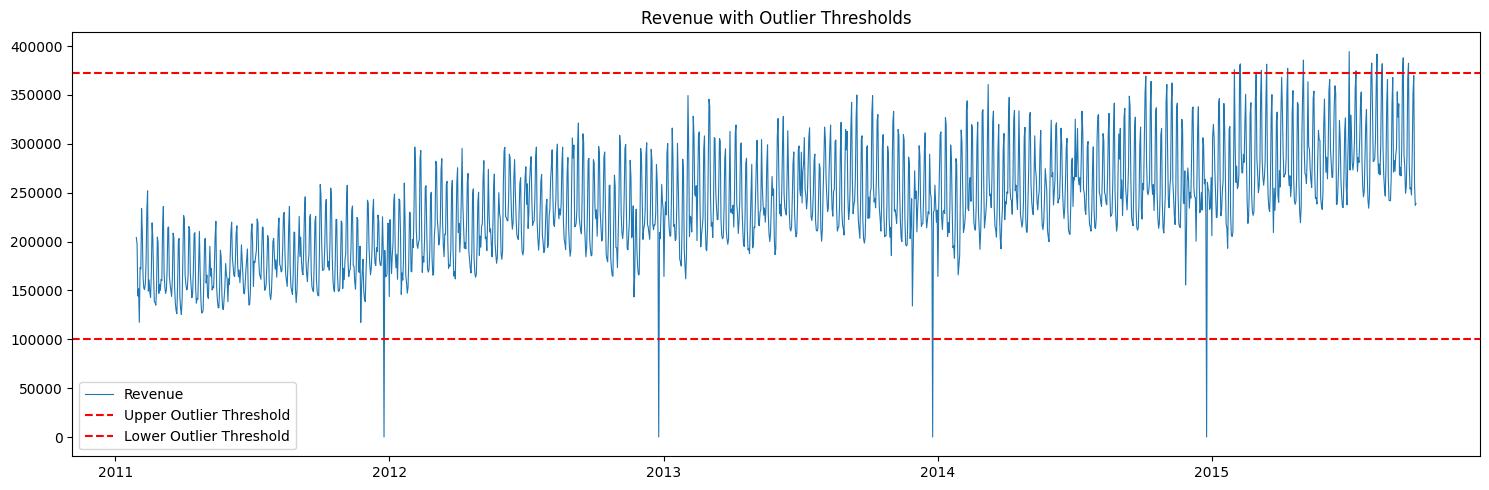

In [14]:
# ------------------- Event/Anomaly Detection ---------------------
# Detect outliers using IQR method
def detect_outliers(train_df, store_id):
    store_data = train_df[train_df['store_id'] == store_id].copy()
    Q1 = store_data['revenue'].quantile(0.25)
    Q3 = store_data['revenue'].quantile(0.75)
    IQR = Q3 - Q1

    outliers = store_data[
        (store_data['revenue'] < Q1 - 1.5 * IQR) |
        (store_data['revenue'] > Q3 + 1.5 * IQR)
    ]

    return outliers[['date', 'revenue']].sort_values('date')

# Check outliers for total revenue
print("Potential outlier dates (All Stores):")
outliers = detect_outliers(train_df, 0)
print(outliers.head(10))

# Visualize outliers
df_total = train_df[train_df['store_id'] == 0].sort_values('date')
Q1 = df_total['revenue'].quantile(0.25)
Q3 = df_total['revenue'].quantile(0.75)
IQR = Q3 - Q1

plt.figure(figsize=(15, 5))
plt.plot(df_total['date'], df_total['revenue'], linewidth=0.8, label='Revenue')
plt.axhline(Q3 + 1.5*IQR, color='r', linestyle='--', label='Upper Outlier Threshold')
plt.axhline(Q1 - 1.5*IQR, color='r', linestyle='--', label='Lower Outlier Threshold')
plt.title('Revenue with Outlier Thresholds')
plt.legend()
plt.tight_layout()
plt.show()



Consider corrected Outlier Detection Strategy

Event/Anomaly Insights
✅ Confirmed Patterns:

- Christmas Day = near-zero revenue every year (100% predictable)
- Multiple major holidays cause 99% revenue drops (need explicit handling)
- 2015 has unusual high-revenue days (requires investigation)
- IQR method flags 2015 growth as outliers (need year-specific thresholds)


🚨 Critical Actions:

- Add holiday features (is_christmas, is_major_holiday)
- Investigate 2015 high outliers - check event column and day_of_week
- Don't remove outliers blindly - holidays are predictable, not anomalies
- Consider separate models for holiday vs. non-holiday days

"# Option 1: Explicit features (best for tree models)
df['is_christmas'] = (df['date'].dt.month == 12) & (df['date'].dt.day == 25)
df['is_christmas'] = df['is_christmas'].astype(int)

"# Option 2: Exclude from training (for some models)
df_train = df[df['revenue'] > 1000]  # Remove near-zero days

"# Option 3: Use a library like 'holidays'
import holidays
us_holidays = holidays.US()
df['is_holiday'] = df['date'].apply(lambda x: x in us_holidays).astype(int)

In [15]:


# ------------------- Correlation Analysis ---------------------

# If you have the 'event' column
if 'event' in train_df.columns:
    # Revenue by event type
    event_revenue = train_df[train_df['store_id'] == 0].groupby('event')['revenue'].agg(['mean', 'median', 'count'])
    print("\nRevenue by Event Type:")
    print(event_revenue.sort_values('mean', ascending=False))

# Weekend vs Weekday
train_df['is_weekend'] = train_df['day_of_week'].isin([5, 6]).astype(int)
weekend_comparison = train_df[train_df['store_id'] == 0].groupby('is_weekend')['revenue'].mean()
print(f"\nWeekday avg: ${weekend_comparison[0]:,.2f}")
print(f"Weekend avg: ${weekend_comparison[1]:,.2f}")
print(f"Weekend lift: {(weekend_comparison[1]/weekend_comparison[0] - 1)*100:.1f}%")


Weekday avg: $217,212.96
Weekend avg: $286,587.35
Weekend lift: 31.9%


In [17]:
# # ------------------- Decomposition Analysis ---------------------

# # Seasonal decomposition
# df_total = train_df[train_df['store_id'] == 0].sort_values('date').set_index('date')
# decomposition_mult = seasonal_decompose(
#     df_total['revenue'],
#     model='multiplicative',
#     period=7
# )

# fig, axes = plt.subplots(4, 1, figsize=(15, 10))
# decomposition.observed.plot(ax=axes[0], title='Observed')
# decomposition.trend.plot(ax=axes[1], title='Trend')
# decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
# decomposition.resid.plot(ax=axes[3], title='Residual')
# plt.tight_layout()
# plt.show()

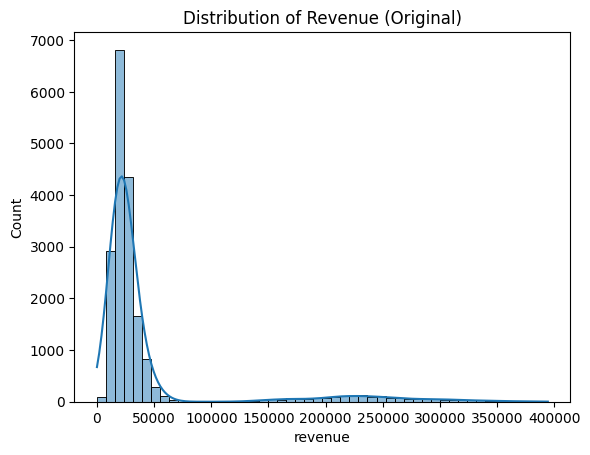

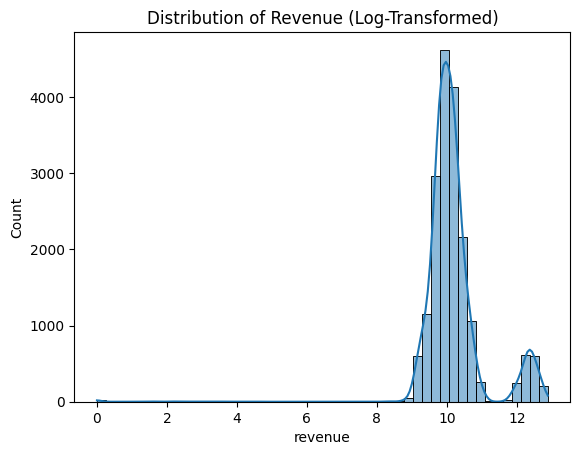

In [18]:
# Let's visualize the revenue distribution
sns.histplot(original_df['revenue'], kde=True, bins=50)
plt.title('Distribution of Revenue (Original)')
plt.show()

# Now apply log1p and visualize again
sns.histplot(np.log1p(original_df['revenue']), kde=True, bins=50)
plt.title('Distribution of Revenue (Log-Transformed)')
plt.show()

## **3. Feature Engineering**



In [19]:
# def create_features(data):
#     """
#     Creates time series features from a datetime index.
#     """
#     # Make a copy to avoid modifying the original dataframe
#     new_df = data.copy()

#     # --- 1. Date-based Features ---
#     # These help the model learn seasonal patterns
#     new_df['date'] = pd.to_datetime(new_df['date'])
#     new_df['day_of_week'] = new_df['date'].dt.dayofweek  # Monday=0, Sunday=6
#     new_df['day_of_month'] = new_df['date'].dt.day
#     new_df['week_of_year'] = new_df['date'].dt.isocalendar().week.astype(int)
#     new_df['month'] = new_df['date'].dt.month
#     new_df['year'] = new_df['date'].dt.year
#     new_df['is_weekend'] = (new_df['day_of_week'] >= 5).astype(int) # 1 for weekend, 0 for weekday

#     # --- 2. Lag Features ---
#     h_forecast = H
#     lags = [h_forecast, h_forecast + 7, h_forecast + 14, h_forecast + 28]

#     # Sort data to ensure lags are correct
#     new_df = new_df.sort_values(['store_id', 'date'])

#     for lag in lags:
#         new_df[f'revenue_lag_{lag}'] = new_df.groupby('store_id')['revenue'].shift(lag)

#     # --- 3. Rolling Window Features ---
#     # These capture recent trends and momentum.
#     # We use a window that starts after the lag period.
#     window_sizes = [7, 14, 28,46]
#     for window in window_sizes:
#         # The shift of h_forecast is crucial to prevent data leakage
#         rolling_series = new_df.groupby('store_id')['revenue'].shift(h_forecast).rolling(window)
#         new_df[f'revenue_roll_mean_{window}'] = rolling_series.mean()
#         new_df[f'revenue_roll_std_{window}'] = rolling_series.std()

#     # --- 4. Event Features ---
#     # Convert text-based events into a format the model can use.
#     # We will use one-hot encoding later, but for now we can make it a categorical type.
#     new_df['event'] = new_df['event'].astype('category')

#     # Convert store_id to category as well, so the model treats it as a label, not a number.
#     new_df['store_id'] = new_df['store_id'].astype('category')

#     return new_df

In [25]:
H_FORECAST

92

In [26]:
df_featured=original_df.copy()
H_FORECAST = H
# --- STEP 1: LOG TRANSFORMATION ---
print("Step 1: Applying log transformation...")
df_featured['revenue'] = np.log1p(df_featured['revenue'])

# --- STEP 2: ENSURE PROPER DATA TYPES & SORTING ---
print("Step 2: Data type conversion and sorting...")
df_featured['date'] = pd.to_datetime(df_featured['date'])
df_featured['store_id'] = df_featured['store_id'].astype('category')
df_featured = df_featured.sort_values(['store_id', 'date']).reset_index(drop=True)

# =============================================================================
# STEP 3: TEMPORAL FEATURES
# =============================================================================
print("Step 3: Creating temporal features...")

# --- 3A: Basic Calendar Features ---
df_featured['year'] = df_featured['date'].dt.year
df_featured['month'] = df_featured['date'].dt.month
df_featured['day_of_month'] = df_featured['date'].dt.day
df_featured['day_of_week'] = df_featured['date'].dt.dayofweek  # 0=Mon, 6=Sun
df_featured['week_of_year'] = df_featured['date'].dt.isocalendar().week.astype(int)
df_featured['quarter'] = df_featured['date'].dt.quarter
df_featured['day_of_year'] = df_featured['date'].dt.dayofyear

# --- 3B: Weekend/Weekday Indicators (EDA: 40% revenue lift on weekends!) ---
df_featured['is_weekend'] = (df_featured['day_of_week'] >= 5).astype(int)
df_featured['is_monday'] = (df_featured['day_of_week'] == 0).astype(int)
df_featured['is_friday'] = (df_featured['day_of_week'] == 4).astype(int)  # Pre-weekend effect

# --- 3C: Trend Features (EDA: Non-linear growth with 2014 dip) ---
# Days since start of dataset
min_date = df_featured['date'].min()
df_featured['days_since_start'] = (df_featured['date'] - min_date).dt.days

# Polynomial trend features (captures non-linear growth)
df_featured['days_since_start_sq'] = df_featured['days_since_start'] ** 2
df_featured['days_since_start_cb'] = df_featured['days_since_start'] ** 3

# Year-based trend (captures 2015 acceleration)
df_featured['years_since_2011'] = df_featured['year'] - 2011

# --- 3D: Cyclical Encoding (helps models understand circular time) ---
# Month cyclical
df_featured['month_sin'] = np.sin(2 * np.pi * df_featured['month'] / 12)
df_featured['month_cos'] = np.cos(2 * np.pi * df_featured['month'] / 12)

# Day of week cyclical (strong 7-day pattern from EDA)
df_featured['dow_sin'] = np.sin(2 * np.pi * df_featured['day_of_week'] / 7)
df_featured['dow_cos'] = np.cos(2 * np.pi * df_featured['day_of_week'] / 7)

# Day of year cyclical (captures annual patterns if any)
df_featured['doy_sin'] = np.sin(2 * np.pi * df_featured['day_of_year'] / 365)
df_featured['doy_cos'] = np.cos(2 * np.pi * df_featured['day_of_year'] / 365)


# =============================================================================
# STEP 4: EVENT & HOLIDAY FEATURES (EDA: Holidays cause 99% drops!)
# =============================================================================
print("Step 4: Creating event and holiday features...")

# --- 4A: Basic Event Indicator ---
df_featured['is_event'] = (df_featured['event'] != 'NoEvent').astype(int)

# --- 4B: Major US Holidays (explicit features for catastrophic drops) ---
df_featured['is_christmas'] = (
    (df_featured['date'].dt.month == 12) & (df_featured['date'].dt.day == 25)
).astype(int)

df_featured['is_new_year'] = (
    (df_featured['date'].dt.month == 1) & (df_featured['date'].dt.day == 1)
).astype(int)

# Thanksgiving (4th Thursday of November - complex logic)
df_featured['is_thanksgiving'] = (
    (df_featured['date'].dt.month == 11) &
    (df_featured['date'].dt.day >= 22) &
    (df_featured['date'].dt.day <= 28) &
    (df_featured['date'].dt.dayofweek == 3)  # Thursday
).astype(int)

# Combined major holiday flag
df_featured['is_major_holiday'] = (
    df_featured['is_christmas'] |
    df_featured['is_new_year'] |
    df_featured['is_thanksgiving']
).astype(int)

# --- 4C: Pre/Post Holiday Effects ---
# Revenue builds before holidays, drops after
df_featured['days_to_christmas'] = (
    pd.to_datetime(df_featured['year'].astype(str) + '-12-25') - df_featured['date']
).dt.days

df_featured['is_pre_christmas'] = (
    (df_featured['days_to_christmas'] > 0) &
    (df_featured['days_to_christmas'] <= 7)
).astype(int)

df_featured['is_post_christmas'] = (
    (df_featured['days_to_christmas'] >= -3) &
    (df_featured['days_to_christmas'] < 0)
).astype(int)

# --- 4D: Month-End Effect (some businesses have end-of-month patterns) ---
df_featured['is_month_end'] = (df_featured['day_of_month'] >= 28).astype(int)
df_featured['is_month_start'] = (df_featured['day_of_month'] <= 3).astype(int)


# =============================================================================
# STEP 5: LAG FEATURES (EDA: Strong autocorrelation at lags 1, 7, 14, 28)
# =============================================================================
print("Step 5: Creating lag features...")

# Based on EDA insights:
# - Lag 1: Strongest predictor (PACF ~0.73)
# - Lag 7: Weekly pattern (PACF ~0.58)
# - Lags 14, 21, 28: Multi-week patterns
# - Long lags (92+): Weak but may capture year-over-year

# Critical lags for H_FORECAST (prevent data leakage)
critical_lags = [
    1,   # Yesterday (most recent available data or prediction)
    7,   # Same day last week
    14,  # 2 weeks ago
    28,  # 4 weeks ago
]

for lag in critical_lags:
    df_featured[f'revenue_lag_{lag}'] = (
        df_featured.groupby('store_id')['revenue'].shift(lag)
    )

# --- Lag features for weekend vs. weekday separately ---
# (EDA: weekends behave differently, separate lags may help)
df_featured['revenue_weekend_lag_7'] = np.where(
    df_featured['is_weekend'] == 1,
    df_featured.groupby('store_id')['revenue'].shift(7),
    np.nan
)
df_featured['revenue_weekday_lag_7'] = np.where(
    df_featured['is_weekend'] == 0,
    df_featured.groupby('store_id')['revenue'].shift(7),
    np.nan
)

# =============================================================================
# STEP 6: ROLLING WINDOW FEATURES (EDA: Capture smoothed trends)
# =============================================================================
print("Step 6: Creating rolling window features...")

# Window sizes based on EDA memory horizon (~30 days) and weekly patterns
window_sizes = [7, 14, 28, 46]

for window in window_sizes:

    rolling_series = (
        df_featured
        .groupby('store_id')['revenue']
        .shift(1)
        .rolling(window=window, min_periods=1)
    )

    # Mean (smoothed trend)
    df_featured[f'revenue_roll_mean_{window}'] = rolling_series.mean()

    # Std (volatility)
    df_featured[f'revenue_roll_std_{window}'] = rolling_series.std()

    # Min/Max (range of recent performance)
    df_featured[f'revenue_roll_min_{window}'] = rolling_series.min()
    df_featured[f'revenue_roll_max_{window}'] = rolling_series.max()

    # Median (robust to outliers)
    df_featured[f'revenue_roll_median_{window}'] = rolling_series.median()

# --- Rolling features for coefficient of variation (CV) ---
# (EDA: Store volatility matters - Stores 8, 9 have high CV)
for window in [7, 28]:
    mean_col = f'revenue_roll_mean_{window}'
    std_col = f'revenue_roll_std_{window}'
    df_featured[f'revenue_roll_cv_{window}'] = (
        df_featured[f'revenue_roll_std_{window}'] /
        (df_featured[f'revenue_roll_mean_{window}'] + 1e-8)  # Avoid division by zero
    )

# --- Rolling sum (total revenue in past N days) ---
for window in [7, 28]:
    rolling_sum = (
        df_featured
        .groupby('store_id')['revenue']
        .shift(1)
        .rolling(window=window, min_periods=1)
        .sum()
    )
    df_featured[f'revenue_roll_sum_{window}'] = rolling_sum

# =============================================================================
# STEP 7: DIFFERENCE FEATURES (Handle non-stationarity)
# =============================================================================
print("Step 7: Creating difference features...")

# First-order differences (removes trend)
df_featured['revenue_diff_1'] = (
    df_featured.groupby('store_id')['revenue'].diff(1)
)

# Weekly differences (removes weekly seasonality)
df_featured['revenue_diff_7'] = (
    df_featured.groupby('store_id')['revenue'].diff(7)
)

# Month-over-month change
df_featured['revenue_diff_28'] = (
    df_featured.groupby('store_id')['revenue'].diff(28)
)

# =============================================================================
# STEP 8: STORE-SPECIFIC FEATURES
# =============================================================================
print("Step 8: Creating store-specific features...")

# --- 8A: Store performance percentile (rank stores by avg revenue) ---
store_avg_revenue = (
    df_featured
    .groupby('store_id')['revenue']
    .transform('mean')
)
df_featured['store_revenue_rank'] = store_avg_revenue.rank(pct=True)

# --- 8B: Store volatility (from EDA: Stores 8, 9 are volatile) ---
store_cv = (
    df_featured
    .groupby('store_id')['revenue']
    .transform(lambda x: x.std() / (x.mean() + 1e-8))
)
df_featured['store_volatility'] = store_cv

# --- 8C: Store growth trend (recent 90 days vs. previous 90 days) ---
def calculate_store_growth(group):
    """Calculate rolling growth rate for each store"""
    recent = group['revenue'].shift(1).rolling(90, min_periods=30).mean()
    past = group['revenue'].shift(91).rolling(90, min_periods=30).mean()
    return (recent - past) / (past + 1e-8)

df_featured['store_growth_rate'] = (
    df_featured
    .groupby('store_id')
    .apply(calculate_store_growth)
    .reset_index(level=0, drop=True)
)

# =============================================================================
# STEP 9: INTERACTION FEATURES (Capture complex patterns)
# =============================================================================
print("Step 9: Creating interaction features...")

# --- 9A: Store × Day of Week (some stores may have different weekend patterns) ---
for dow in range(7):
    df_featured[f'store_dow_{dow}_interaction'] = (
        (df_featured['day_of_week'] == dow).astype(int) *
        df_featured['store_id'].cat.codes  # Convert category to numeric for multiplication
    )

# --- 9B: Weekend × Month (weekend effect may vary by season) ---
df_featured['weekend_month_interaction'] = (
    df_featured['is_weekend'] * df_featured['month']
)

# --- 9C: Event × Weekend (events on weekends may have amplified effect) ---
df_featured['event_weekend_interaction'] = (
    df_featured['is_event'] * df_featured['is_weekend']
)

# --- 9D: Trend × Store (different stores have different growth rates) ---
df_featured['trend_store_interaction'] = (
    df_featured['days_since_start'] * df_featured['store_id'].cat.codes
)
# =============================================================================
# STEP 10: EXPANDING WINDOW FEATURES (Capture long-term trends)
# =============================================================================
print("Step 10: Creating expanding window features...")

# Expanding mean (all-time average up to this point)
df_featured['revenue_expanding_mean'] = (
    df_featured
    .groupby('store_id')['revenue']
    .shift(1)
    .expanding(min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

# Expanding std (all-time volatility)
df_featured['revenue_expanding_std'] = (
    df_featured
    .groupby('store_id')['revenue']
    .shift(1)
    .expanding(min_periods=1)
    .std()
    .reset_index(level=0, drop=True)
)

# =============================================================================
# STEP 10: COMPARATIVE FEATURES (Compare to benchmarks)
# =============================================================================
print("Step 10: Creating comparative features...")

# --- 10A: Deviation from store's own average ---
df_featured['revenue_vs_store_avg'] = (
    df_featured[f'revenue_lag_1'] -
    df_featured['revenue_expanding_mean']
)

# --- 10B: Deviation from rolling average ---
df_featured['revenue_vs_roll_mean_28'] = (
    df_featured[f'revenue_lag_1'] -
    df_featured['revenue_roll_mean_28']
)

# --- 10C: Z-score (standardized deviation) ---
df_featured['revenue_zscore_28'] = (
    (df_featured[f'revenue_lag_1'] - df_featured['revenue_roll_mean_28']) /
    (df_featured['revenue_roll_std_28'] + 1e-8)
)

# =============================================================================
# STEP 11: FUTURE-SAFE FEATURE VALIDATION
# =============================================================================
print("Step 11: Validating features for forecasting safety...")

# List features that should NOT contain future information
# (All lags shifted by H_FORECAST, all rolling windows shifted by H_FORECAST)

# for debugging
critical_features = [
    'day_of_week', 'is_weekend', 'month', 'year',
    'is_major_holiday', f'revenue_lag_{H_FORECAST}'
]

for feat in critical_features:
    if feat in df_featured.columns:
        nan_count = df_featured[feat].isna().sum()
        if nan_count > 0:
            print(f"  ⚠️ Warning: {feat} has {nan_count} NaN values")

# =============================================================================
# FINALIZATION
# =============================================================================
print("Finalizing...")
# --- Drop rows with NaN (due to lags/rolling windows) ---
rows_before = len(df_featured)
essential_features = [
    'revenue', 'day_of_week', 'is_weekend',
    'revenue_lag_1',  # ✅ Yesterday
    'revenue_lag_7',  # ✅ Last week
    'revenue_lag_28', # ✅ 4 weeks ago
    'revenue_roll_mean_7',
    'revenue_roll_mean_28',
]
df_featured = df_featured.dropna(subset=essential_features)
df_featured = df_featured.fillna(0)  # Fill remaining NaNs
rows_after = len(df_featured)
print(f"  Dropped {rows_before - rows_after} rows with NaN values")

# --- Convert event to categorical dummy variables ---

df_featured['event'] = df_featured['event'].astype('category')

# --- Ensure store_id remains categorical ---
df_featured['store_id'] = df_featured['store_id'].astype('category')

print("\n" + "="*70)
print("FEATURE ENGINEERING COMPLETE")
print("="*70)

print(f"\nDataset shape: {df_featured.shape}")
print(f"Date range: {df_featured['date'].min()} to {df_featured['date'].max()}")
print(f"Number of stores: {df_featured['store_id'].nunique()}")
print(f"Number of features: {len(df_featured.columns)}")

print("\nSample of engineered features:")
print(df_featured.head(3))

print("\nAll columns:")
print(df_featured.columns.tolist())


Step 1: Applying log transformation...
Step 2: Data type conversion and sorting...
Step 3: Creating temporal features...
Step 4: Creating event and holiday features...
Step 5: Creating lag features...
Step 6: Creating rolling window features...
Step 7: Creating difference features...
Step 8: Creating store-specific features...
Step 9: Creating interaction features...
Step 10: Creating expanding window features...
Step 10: Creating comparative features...
Step 11: Validating features for forecasting safety...
Finalizing...
  Dropped 308 rows with NaN values

FEATURE ENGINEERING COMPLETE

Dataset shape: (18458, 86)
Date range: 2011-02-26 00:00:00 to 2015-09-30 00:00:00
Number of stores: 11
Number of features: 86

Sample of engineered features:
   store_id  store_name       date    revenue    event  year  month  \
28        0  All Stores 2011-02-26  12.228811  NoEvent  2011      2   
29        0  All Stores 2011-02-27  12.199195  NoEvent  2011      2   
30        0  All Stores 2011-02-28 

In [ ]:
# # --- Apply the feature engineering function ---
# df_featured['revenue'] = np.log1p(df_featured['revenue'])

# # --- 1. Date-based Features ---
# df_featured['date'] = pd.to_datetime(df_featured['date'])
# df_featured['day_of_week'] = df_featured['date'].dt.dayofweek  # Monday=0, Sunday=6
# df_featured['day_of_month'] = df_featured['date'].dt.day
# df_featured['week_of_year'] = df_featured['date'].dt.isocalendar().week.astype(int)
# df_featured['month'] = df_featured['date'].dt.month
# df_featured['year'] = df_featured['date'].dt.year
# df_featured['is_weekend'] = (df_featured['day_of_week'] >= 5).astype(int) # 1 for weekend, 0 for weekday

# # --- 2. Lag Features ---
# h_forecast = H
# lags = [h_forecast, h_forecast + 7, h_forecast + 14, h_forecast + 28]

# # Sort data to ensure lags are correct
# df_featured = df_featured.sort_values(['store_id', 'date'])

# for lag in lags:
#     df_featured[f'revenue_lag_{lag}'] = df_featured.groupby('store_id')['revenue'].shift(lag)

# # --- 3. Rolling Window Features ---
# window_sizes = [7, 14, 28,46]
# for window in window_sizes:
#     # The shift of h_forecast is crucial to prevent data leakage
#     rolling_series = df_featured.groupby('store_id')['revenue'].shift(h_forecast).rolling(window)
#     df_featured[f'revenue_roll_mean_{window}'] = rolling_series.mean()
#     df_featured[f'revenue_roll_std_{window}'] = rolling_series.std()

# # --- 4. Event Features ---
# df_featured['event'] = df_featured['event'].astype('category')
# df_featured['is_event'] = (df_featured['event'] != 'NoEvent').astype(int)

# # Convert store_id to category as well, so the model treats it as a label, not a number.
# df_featured['store_id'] = df_featured['store_id'].astype('category')

# # Drop rows with NaN values created by lags and rolling windows
# df_featured.dropna(inplace=True)
# print(df_featured.head())
# print(df_featured.columns)


In [27]:
# Check if these are specific days of the week
df_store=df_featured[df_featured['store_id'] == 0]
high_outliers = df_store[df_store['date'].isin(['2015-01-31', '2015-02-07', '2015-02-08',
                                     '2015-03-08', '2015-03-15', '2015-04-12'])]
print(high_outliers[['date', 'revenue','store_id' ,'day_of_week', 'event']])

# Check if this is a data error - are they all the same day pattern?
print(high_outliers['day_of_week'].value_counts())

# Compare to normal 2015 Saturdays
normal_saturdays_2015 = df_store[(df_store['year'] == 2015) & (df_store['day_of_week'] == 5) &
                            (~df_store['date'].isin(high_outliers['date']))]
print(f"Normal 2015 Saturday avg: {normal_saturdays_2015['revenue'].mean()}")

           date    revenue store_id  day_of_week           event
1463 2015-01-31  12.837147        0            5         NoEvent
1470 2015-02-07  12.846721        0            5         NoEvent
1471 2015-02-08  12.852526        0            6         NoEvent
1499 2015-03-08  12.834531        0            6         NoEvent
1506 2015-03-15  12.851656        0            6         NoEvent
1534 2015-04-12  12.840518        0            6  OrthodoxEaster
day_of_week
6    4
5    2
Name: count, dtype: int64
Normal 2015 Saturday avg: 12.73586678891733


Save in drive

In [28]:
# --- Save Processed DataFrames ---

PROJECT_PATH = '/content/drive/MyDrive/M5_Project/'
output_folder = PROJECT_PATH + 'processed_data/'

# 1. Save the main featured dataframe
df_featured.to_parquet(output_folder + 'df_featured.parquet', engine='pyarrow')

# 2. Save the original merged dataframe
original_df.to_parquet(output_folder + 'original_df.parquet', engine='pyarrow')

print(f"Successfully saved files to: {output_folder}")
print(os.listdir(output_folder)) # List files to confirm they were saved

Successfully saved files to: /content/drive/MyDrive/M5_Project/processed_data/
['original_df.parquet', 'df_featured.parquet']


Split train/test

In [29]:
# # --- train and validation sets from the FEATURED data ---
# last_train_date_featured = df_featured['date'].max() - pd.to_timedelta(H, unit='D')
# validation_start_date_featured = last_train_date_featured + pd.to_timedelta(1, unit='D')

# train_final = df_featured[df_featured['date'] <= last_train_date_featured]
# val_final = df_featured[df_featured['date'] >= validation_start_date_featured]

# # --- Define our features (X) and target (y) ---
# TARGET = 'revenue'

# FEATURES = [col for col in train_final.columns if col not in [TARGET, 'store_name', 'date', 'weekday', 'event']]

# X_train = train_final[FEATURES]
# y_train = train_final[TARGET]

# X_val = val_final[FEATURES]
# y_val = val_final[TARGET]

# print("Training data shape (X, y):", X_train.shape, y_train.shape)
# print("Validation data shape (X, y):", X_val.shape, y_val.shape)
# print("\nHere are a few of the features we created:")
# print(X_train.head())